# Depth dataset analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import iqr
import cv2

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# Positioning ROIs:
# Body
POS_BODY_FILE = '../data/positions/roi_position.pkl'
# Antenna
POS_ANTENNA_FILE = '../data/positions/antenna_position.pkl'
# Dataset of depth captures
DEPTH_DATASET_FILE = '../data/positions/c_2021_24_07_17_42_37_depth.pkl'
# ROI defined for the dataset
ROI_DEFINITION_FILE = '../data/positions/roi.pkl'
# Original image size
ORIGINAL_WIDTH = 640
ORIGINAL_HEIGHT = 400
# These parameters come from intrinsics matrix (RIGHT)
CX = 318.04592896
CY = 198.99064636
FX = 427.05795288
FY = 427.38696289

In [4]:
fidant = open(POS_ANTENNA_FILE, 'rb')
antenna = pickle.load(fidant)
fidbod = open(POS_BODY_FILE, 'rb')
body = pickle.load(fidbod)
fid = open(DEPTH_DATASET_FILE, 'rb')
ds = pickle.load(fid)
fidroi = open(ROI_DEFINITION_FILE, "rb")
roi = pickle.load(fidroi)

In [5]:
antenna

{'absolute': {'topx': 97, 'topy': 51, 'bottomx': 76, 'bottomy': 69},
 'relative': {'topx': 0.1515625,
  'topy': 0.1275,
  'bottomx': 0.11875,
  'bottomy': 0.1725},
 'x': -314.7727966308594,
 'y': 188.3256072998047,
 'z': 594.0}

In [6]:
body

{'topl': [0.45, 0.15000000000000008],
 'bottomr': [0.65, 0.35],
 'x': 65.58332824707031,
 'y': 204.94790649414062,
 'z': 905.0}

In [7]:
roi

{'right_hand': {'topx': 0.1828125,
  'bottomx': 0.5359375,
  'topy': 0.04,
  'bottomy': 0.455},
 'left_hand': {'topx': 0.709375,
  'bottomx': 0.9203125,
  'topy': 0.175,
  'bottomy': 0.6625}}

In [8]:
# Antenna
x1 = int(antenna['absolute']['topx'])
x2 = int(antenna['absolute']['bottomx'])
z = antenna['z']
x1_ant_mm = ((x1 - CX)*z)/FX
x2_ant_mm = ((x2 - CX)*z)/FX

In [9]:
antenna['absolute']['topx'], antenna['absolute']['bottomx'], x1_ant_mm, x2_ant_mm

(97, 76, -307.45541891157484, -336.6645693696746)

In [10]:
# Righ Hand
x1 = int(roi['right_hand']['topx']*ORIGINAL_WIDTH)
x2 = int(roi['right_hand']['bottomx']*ORIGINAL_WIDTH)
z = antenna['z']
x1_rh_mm = ((x1 - CX)*z)/FX
x2_rh_mm = ((x2 - CX)*z)/FX

In [11]:
x1, x2, x1_rh_mm, x2_rh_mm

(117, 343, -279.6371803800513, 34.70891502616521)

In [12]:
# Righ Hand ROI limit (body)
x1 = int(roi['right_hand']['topx']*ORIGINAL_WIDTH)
x2 = int(roi['right_hand']['bottomx']*ORIGINAL_WIDTH)
z = body['z']
x1_rh_body_mm = ((x1 - CX)*z)/FX
x2_rh_body_mm = ((x2 - CX)*z)/FX

In [13]:
x1, x2, x1_rh_body_mm, x2_rh_body_mm

(117, 343, -426.0465458652297, 52.881427775554734)

In [14]:
# Process dataset
dm_lh = []
dm_rh = []
for dm in ds:
    if dm['hand'] == 'left':
        dm_lh.append(dm)
    else:
        dm_rh.append(dm)

In [15]:
size_lh = len(dm_lh)
size_rh = len(dm_rh)

depth_map_dim_lh = dm_lh[0]['depth_map'].shape
depth_map_dim_rh = dm_rh[0]['depth_map'].shape

from_ts_lh = dm_lh[0]['timestamp']
to_ts_lh = dm_lh[size_lh-1]['timestamp']

from_ts_rh = dm_rh[0]['timestamp']
to_ts_rh = dm_rh[size_rh-1]['timestamp']

from_frame_num_lh = dm_lh[0]['frame']
to_frame_num_lh = dm_lh[size_lh-1]['frame']

from_frame_num_rh = ds[0]['frame']
to_frame_num_rh = ds[size_rh-1]['frame']

roi_topx_lh = int(roi['left_hand']['topx'] * ORIGINAL_WIDTH)
roi_bottomx_lh = int(roi['left_hand']['bottomx'] * ORIGINAL_WIDTH)
roi_topy_lh = int(roi['left_hand']['topy'] * ORIGINAL_HEIGHT)
roi_bottomy_lh = int(roi['left_hand']['bottomy'] * ORIGINAL_HEIGHT)

roi_topx_rh = int(roi['right_hand']['topx'] * ORIGINAL_WIDTH)
roi_bottomx_rh = int(roi['right_hand']['bottomx'] * ORIGINAL_WIDTH)
roi_topy_rh = int(roi['right_hand']['topy'] * ORIGINAL_HEIGHT)
roi_bottomy_rh = int(roi['right_hand']['bottomy'] * ORIGINAL_HEIGHT)

## Dataset Metadata - Left Hand

In [16]:
print(f"Dataset size = {size_lh} frames")
print(f"Depth map width = {depth_map_dim_lh[1]} pixels")
print(f"Depth map height = {depth_map_dim_lh[0]} pixels")
print(f"From time = {from_ts_lh}")
print(f"To time = {to_ts_lh}")
print(f"From frame = {from_frame_num_lh}")
print(f"To frame = {to_frame_num_lh}")
print(f"ROI top (x,y) = ({roi_topx_lh},{roi_topy_lh})")
print(f"ROI bottom (x,y) = ({roi_bottomx_lh},{roi_bottomy_lh})")

Dataset size = 451 frames
Depth map width = 136 pixels
Depth map height = 196 pixels
From time = 2021-07-24 17:43:35.550569
To time = 2021-07-24 17:43:50.557400
From frame = 1677
To frame = 2127
ROI top (x,y) = (454,70)
ROI bottom (x,y) = (589,265)


## Dataset Metadata - Right Hand

In [17]:
print(f"Dataset size = {size_rh} frames")
print(f"Depth map width = {depth_map_dim_rh[1]} pixels")
print(f"Depth map height = {depth_map_dim_rh[0]} pixels")
print(f"From time = {from_ts_rh}")
print(f"To time = {to_ts_rh}")
print(f"From frame = {from_frame_num_rh}")
print(f"To frame = {to_frame_num_rh}")
print(f"ROI top (x,y) = ({roi_topx_rh},{roi_topy_rh})")
print(f"ROI bottom (x,y) = ({roi_bottomx_rh},{roi_bottomy_rh})")

Dataset size = 451 frames
Depth map width = 227 pixels
Depth map height = 167 pixels
From time = 2021-07-24 17:43:35.550569
To time = 2021-07-24 17:43:50.557400
From frame = 1677
To frame = 1902
ROI top (x,y) = (117,16)
ROI bottom (x,y) = (343,182)


## Inspect Dataset (Right Hand)

In [18]:
size = size_rh

In [19]:
dataset = dm_rh

In [20]:
CURRENT_SLICE = 0
slice_size = 16
slices = size//slice_size + (0 if size%slice_size==0 else 1)
def show_slice(slice_number):
    global CURRENT_SLICE
    slice_ = dataset[slice_number*slice_size:min(slice_number*slice_size+slice_size,size)]
    images_per_row = 4
    rows = slice_size//images_per_row
    fig, axs = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(16,10))
    for idx, sl_ in enumerate(slice_):
        fn = slice_number*slice_size + idx
        row, col = idx//rows, idx%rows
        axs[row,col].imshow(sl_['depth_map'], cmap='Spectral')
        axs[row,col].set_title(f"frame {fn}")
        axs[row,col].tick_params(
            left=False, 
            right=False, 
            labelleft=False,
            labelbottom=False, 
            bottom = False
        )    
    fig.tight_layout()
    plt.show()
    CURRENT_SLICE = slice_number

In [21]:
interact(show_slice, 
         slice_number=widgets.IntSlider(min=0, max=slices-1, step=1, description='Select Slice')
)

interactive(children=(IntSlider(value=0, description='Select Slice', max=28), Output()), _dom_classes=('widget…

<function __main__.show_slice(slice_number)>

## Thresholding Depth Values

In [111]:
body_buffer = 50
antenna_buffer = 5

In [112]:
# Hard limits
# Max depth
MAX_DEPTH_VALUE = body['z'] - body_buffer
# Min depth
MIN_DEPTH_VALUE = antenna['z'] + antenna_buffer

In [113]:
MAX_DEPTH_VALUE, MIN_DEPTH_VALUE

(855.0, 599.0)

In [114]:
# Show dataset filtered
def show_filtered_slice(slice_number):
    slice_ = dataset[slice_number*slice_size:min(slice_number*slice_size+slice_size,size)]
    images_per_row = 4
    rows = slice_size//images_per_row
    fig, axs = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(16,10))
    for idx, sl_ in enumerate(slice_):
        fn = slice_number*slice_size + idx
        row, col = idx//rows, idx%rows
        # Max values turn to 0 for display
        dm_ = sl_['depth_map'].copy()
        filter_1 = dm_ > MAX_DEPTH_VALUE
        dm_[filter_1] = 2**16
        axs[row,col].imshow(dm_, cmap='rainbow')
        axs[row,col].set_title(f"frame {fn}")
        axs[row,col].tick_params(
            left=False, 
            right=False, 
            labelleft=False,
            labelbottom=False, 
            bottom = False
        )    
    fig.tight_layout()
    plt.show()

In [115]:
CURRENT_SLICE

25

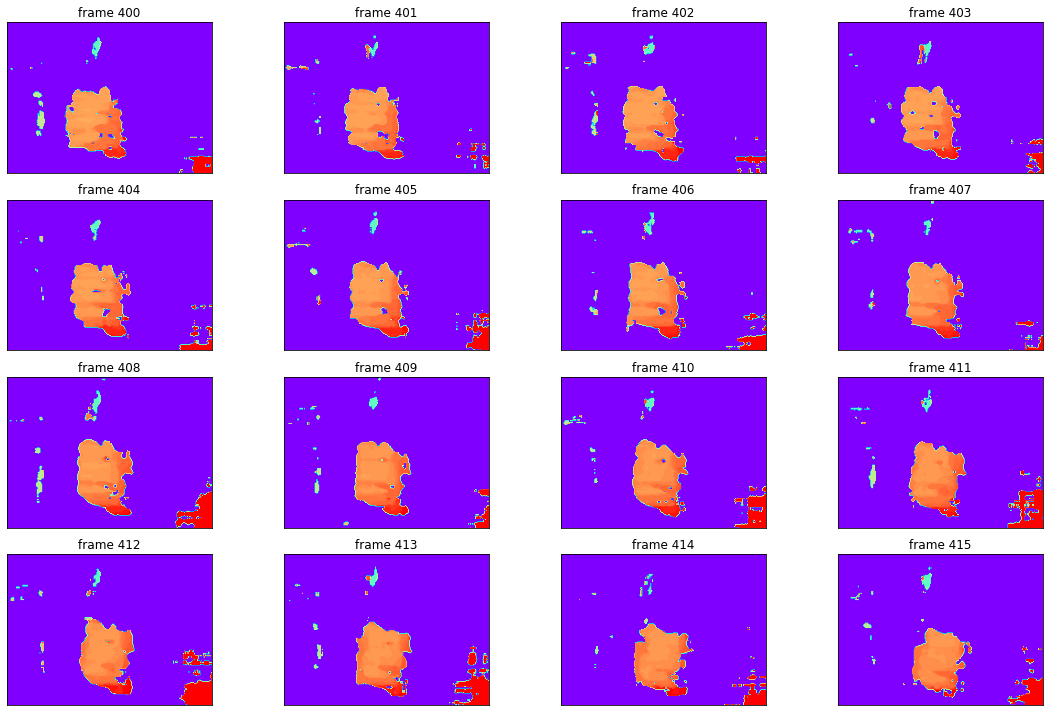

In [116]:
show_filtered_slice(CURRENT_SLICE)

## Select a Frame to inspect

In [117]:
FRAME = 407

In [118]:
dm_frame = dataset[FRAME]['depth_map']
frame_number = dataset[FRAME]['frame']
ts = dataset[FRAME]['timestamp']

In [119]:
filter_cond = (dm_frame > MAX_DEPTH_VALUE) | (dm_frame < MIN_DEPTH_VALUE)
dm_frame_filtered = dm_frame.copy()
dm_frame_filtered_idxs = np.argwhere(~filter_cond)
dm_frame_filtered_values = dm_frame[~filter_cond].flatten()
dm_frame_filtered[filter_cond] = 2**16

In [120]:
# Some statistics of the frame depth values
print("Statistics of Thresholed Frame")
print(f"Size = {len(dm_frame_filtered_values)}")
print(f"Min = {np.max(dm_frame_filtered_values)}")
print(f"Max = {np.min(dm_frame_filtered_values)}")
print(f"Mean = {np.mean(dm_frame_filtered_values)}")
print(f"Median = {np.median(dm_frame_filtered_values)}")
print(f"Std = {np.std(dm_frame_filtered_values)}")

Statistics of Thresholed Frame
Size = 4009
Min = 850
Max = 603
Mean = 715.7009229234224
Median = 690.0
Std = 52.893286692620215


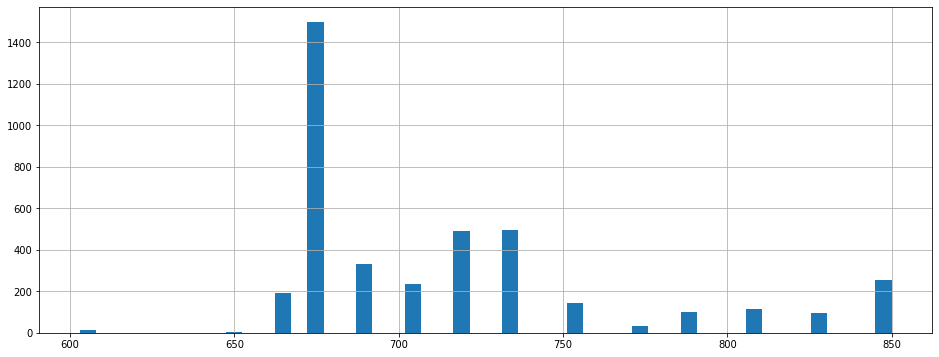

In [121]:
fig = plt.figure(figsize=(16,6))
plt.grid()
plt.hist(dm_frame_filtered_values, bins=50)
plt.show()

In [122]:
dm_frame_filtered.shape

(167, 227)

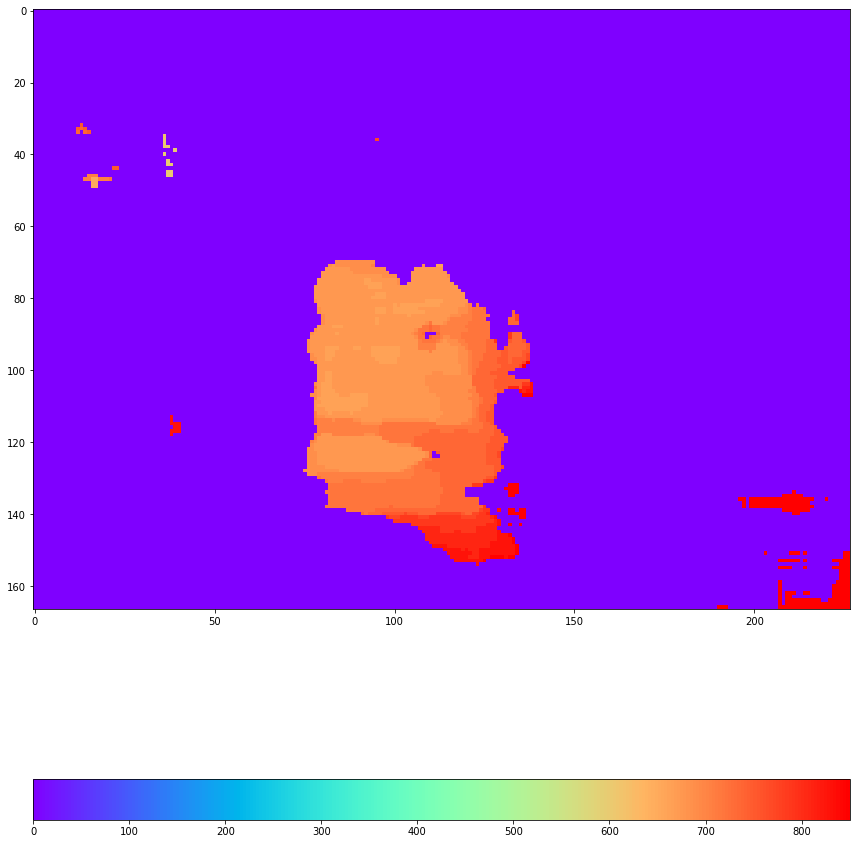

In [123]:
fig = plt.figure(figsize=(12,16))
plt.imshow(dm_frame_filtered, cmap='rainbow')
plt.colorbar(orientation='horizontal')
fig.tight_layout()
plt.show()

In [124]:
# Numpy version is faster
def xyz_numpy(frame, idxs, topx, topy, cx, cy, fx, fy):
    u = idxs[:,1]
    v = idxs[:,0]
    z = frame[v,u]
    x = ((u + topx - cx)*z)/fx
    y = ((v + topy - cy)*z)/fy
    return x, y, z

## Plot X, Z Projection

In [125]:
# Filtered
dm_ = dm_frame.copy()
filter_cond = (dm_ > MAX_DEPTH_VALUE) | (dm_ < MIN_DEPTH_VALUE)
dm_frame_filtered_idxs = np.argwhere(~filter_cond)
x, y, z = xyz_numpy(dm_, dm_frame_filtered_idxs, roi_topx_rh, roi_topy_rh, CX, CY, FX, FY)

In [126]:
# Centroids
centroid_x = np.mean(x)
centroid_z = np.mean(z)
centroid_y = np.mean(y)
# Quantiles
Q1_z = np.quantile(z, 0.25)
Q3_z = np.quantile(z, 0.75)
iqr_z = Q3_z - Q1_z
Q1_x = np.quantile(x, 0.25)
Q3_x = np.quantile(x, 0.75)
iqr_x = Q3_x - Q1_x
Q1_y = np.quantile(y, 0.25)
Q3_y = np.quantile(y, 0.75)
iqr_y = Q3_y - Q1_y

In [127]:
centroid_x, centroid_z

(-150.4514225860901, 715.7009229234224)

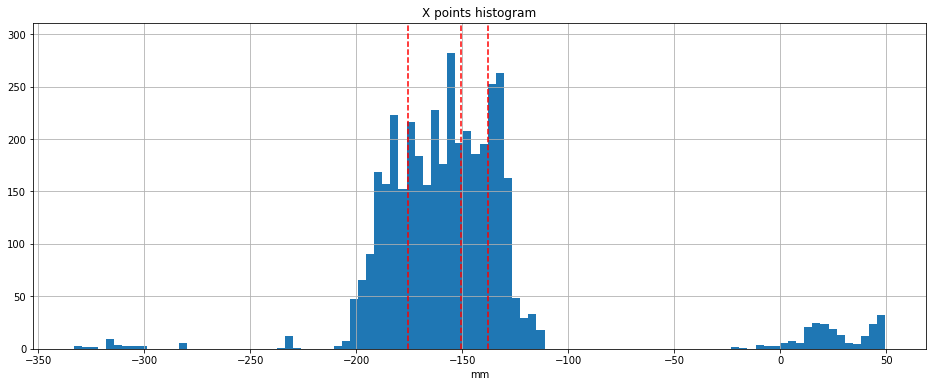

In [128]:
fig, ax = plt.subplots(figsize=(16,6))
plt.grid()
ax.hist(x, bins=100)
ax.set_title("X points histogram")
ax.set_xlabel("mm")
y0, y1 = ax.get_ylim()
ax.axline((centroid_x, y0), (centroid_x, y1), color='r', ls='dashed')
ax.axline((Q1_x, y0), (Q1_x, y1), color='r', ls='dashed')
ax.axline((Q3_x, y0), (Q3_x, y1), color='r', ls='dashed')
plt.show()

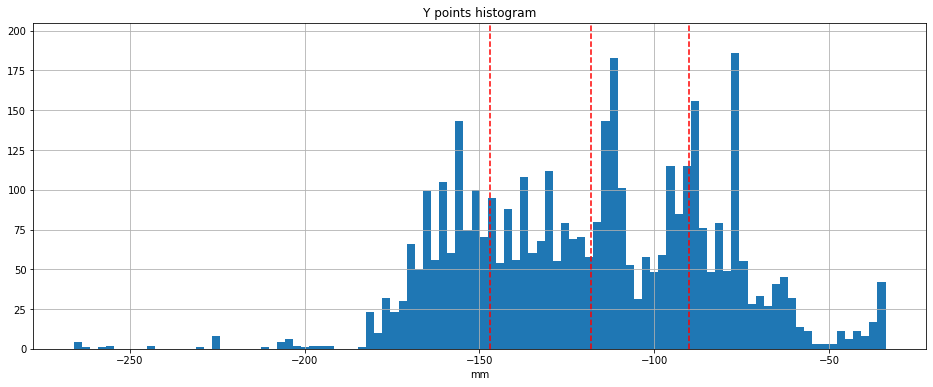

In [129]:
fig, ax = plt.subplots(figsize=(16,6))
plt.grid()
ax.hist(y, bins=100)
ax.set_title("Y points histogram")
ax.set_xlabel("mm")
y0, y1 = ax.get_ylim()
ax.axline((centroid_y, y0), (centroid_y, y1), color='r', ls='dashed')
ax.axline((Q1_y, y0), (Q1_y, y1), color='r', ls='dashed')
ax.axline((Q3_y, y0), (Q3_y, y1), color='r', ls='dashed')
plt.show()

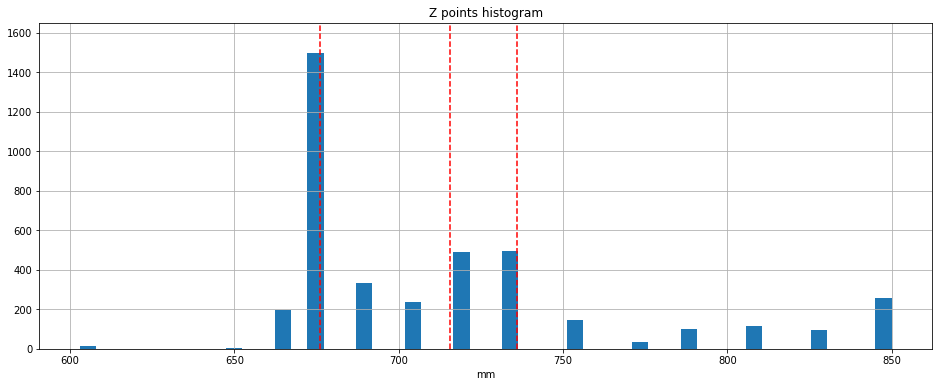

In [130]:
fig, ax = plt.subplots(figsize=(16,6))
plt.grid()
ax.hist(z, bins=50)
ax.set_title("Z points histogram")
ax.set_xlabel("mm")
y0, y1 = ax.get_ylim()
ax.axline((centroid_z, y0), (centroid_z, y1), color='r', ls='dashed')
ax.axline((Q1_z, y0), (Q1_z, y1), color='r', ls='dashed')
ax.axline((Q3_z, y0), (Q3_z, y1), color='r', ls='dashed')
plt.show()

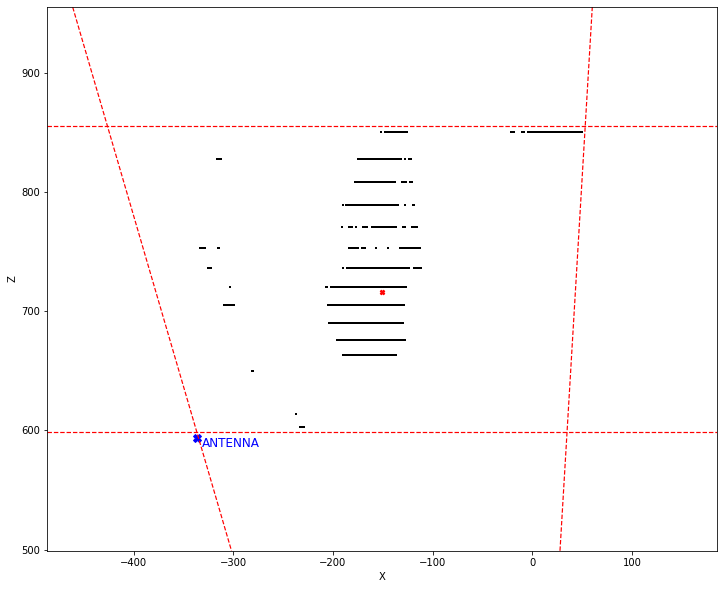

In [131]:
fig, ax = plt.subplots(figsize=(12,10))
plot = ax.scatter(x, z, marker='+', color='k', s=2.2)
ax.set_xlim((x2_ant_mm-150, x2_rh_mm+150))
plt.ylim((MIN_DEPTH_VALUE-100, MAX_DEPTH_VALUE+100))
ax.scatter(centroid_x, centroid_z, marker='X', color='r', s=20)
ax.plot(x2_ant_mm,antenna['z'], marker='X', color='b', ms=8)
ax.text(x2_ant_mm+5, antenna['z']-8, 'ANTENNA', color='b', fontsize='large')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.axline((x0, MIN_DEPTH_VALUE), (x1, MIN_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x0, MAX_DEPTH_VALUE), (x1, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x2_ant_mm, MIN_DEPTH_VALUE), (x1_rh_body_mm, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x2_rh_mm, MIN_DEPTH_VALUE), (x2_rh_body_mm, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.set_xlabel("X")
ax.set_ylabel("Z")
plt.show()

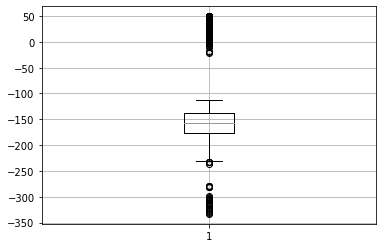

In [132]:
plt.grid()
plt.boxplot(x)
plt.show()

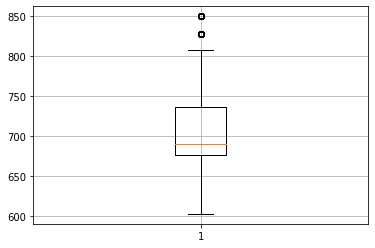

In [133]:
plt.grid()
plt.boxplot(z)
plt.show()

In [134]:
Q1_z, Q3_z, iqr_z

(676.0, 736.0, 60.0)

In [135]:
Q1_x, Q3_x, iqr_x

(-175.77719246468004, -137.95271418611034, 37.8244782785697)

In [136]:
lim_z1 = Q1_z - 1.5*iqr_z
lim_z2 = Q3_z + 1.5*iqr_z
lim_x1 = Q1_x - 1.5*iqr_x
lim_x2 = Q3_x - 1.5*iqr_x

In [137]:
lim_z1, lim_z2, lim_x1, lim_x2

(586.0, 826.0, -232.5139098825346, -194.6894316039649)

In [138]:
points_xz = np.vstack([x, z])

In [139]:
points_xz.shape

(2, 4009)

In [140]:
cond_x = (points_xz[0,:]>=lim_x1) & (points_xz[0,:]<=lim_x2)
cond_z = (points_xz[1,:]>=lim_z1) & (points_xz[1,:]<=lim_z2)

In [141]:
filtered_xz = points_xz[:,cond_x | cond_z]

In [142]:
filtered_xz.shape

(2, 3657)

In [143]:
filtered_centroid_x = np.mean(filtered_xz[0,:])
filtered_centroid_z = np.mean(filtered_xz[1,:])

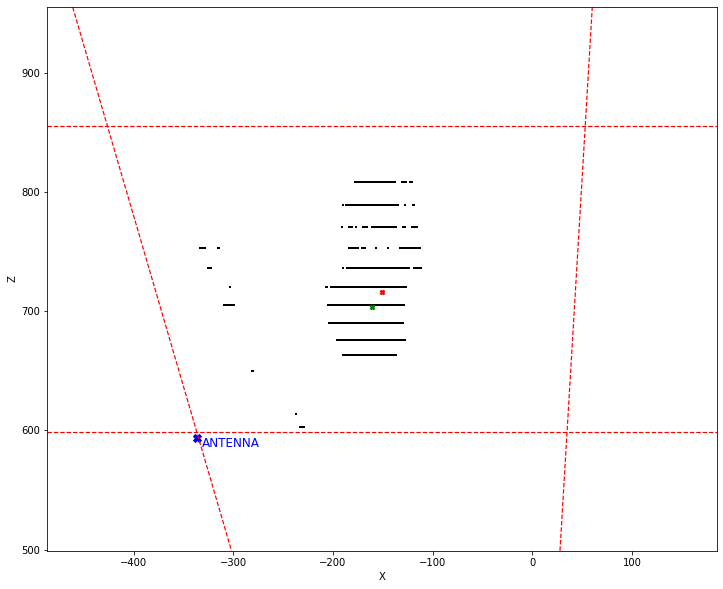

In [144]:
fig, ax = plt.subplots(figsize=(12,10))
plot = ax.scatter(filtered_xz[0,:], filtered_xz[1,:], marker='+', color='k', s=2.2)
ax.set_xlim((x2_ant_mm-150, x2_rh_mm+150))
plt.ylim((MIN_DEPTH_VALUE-100, MAX_DEPTH_VALUE+100))
ax.scatter(centroid_x, centroid_z, marker='X', color='r', s=20)
ax.scatter(filtered_centroid_x, filtered_centroid_z, marker='X', color='g', s=20)
ax.plot(x2_ant_mm,antenna['z'], marker='X', color='b', ms=8)
ax.text(x2_ant_mm+5, antenna['z']-8, 'ANTENNA', color='b', fontsize='large')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.axline((x0, MIN_DEPTH_VALUE), (x1, MIN_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x0, MAX_DEPTH_VALUE), (x1, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x2_ant_mm, MIN_DEPTH_VALUE), (x1_rh_body_mm, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x2_rh_mm, MIN_DEPTH_VALUE), (x2_rh_body_mm, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.set_xlabel("X")
ax.set_ylabel("Z")
plt.show()

In [145]:
# Filter again but with Q1_z
cond_z_fingers = (filtered_xz[1,:] <=Q1_z)
filtered_f_xz = filtered_xz[:,cond_z_fingers]
fing_centroid_x = np.mean(filtered_f_xz[0,:])
fing_centroid_z = np.mean(filtered_f_xz[1,:])

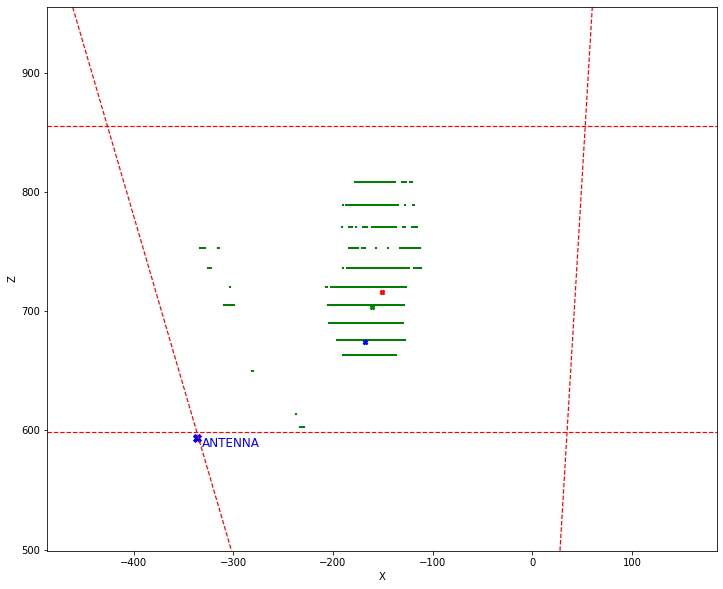

In [146]:
fig, ax = plt.subplots(figsize=(12,10))
plot = ax.scatter(filtered_f_xz[0,:], filtered_f_xz[1,:], marker='+', color='k', s=2.2)
plot = ax.scatter(filtered_xz[0,:], filtered_xz[1,:], marker='+', color='g', s=2.2)
ax.set_xlim((x2_ant_mm-150, x2_rh_mm+150))
plt.ylim((MIN_DEPTH_VALUE-100, MAX_DEPTH_VALUE+100))
ax.scatter(centroid_x, centroid_z, marker='X', color='r', s=20)
ax.scatter(filtered_centroid_x, filtered_centroid_z, marker='X', color='g', s=20)
ax.scatter(fing_centroid_x, fing_centroid_z, marker='X', color='b', s=20)
ax.plot(x2_ant_mm,antenna['z'], marker='X', color='b', ms=8)
ax.text(x2_ant_mm+5, antenna['z']-8, 'ANTENNA', color='b', fontsize='large')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.axline((x0, MIN_DEPTH_VALUE), (x1, MIN_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x0, MAX_DEPTH_VALUE), (x1, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x2_ant_mm, MIN_DEPTH_VALUE), (x1_rh_body_mm, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.axline((x2_rh_mm, MIN_DEPTH_VALUE), (x2_rh_body_mm, MAX_DEPTH_VALUE), ls='dashed', color='r', linewidth=1.2)
ax.set_xlabel("X")
ax.set_ylabel("Z")
plt.show()

## Write a slice into point cloud files for future inspection

In [46]:
def xyz(frame, idxs, topx, topy, cx, cy, fx, fy):
    xyz_c = []
    for v, u in idxs:
        z = frame[v, u]
        x = ((u + topx - cx)*z)/fx
        y = ((v + topy - cy)*z)/fy
        xyz_c.append([x,y,z])
    return xyz_c

In [47]:
CURRENT_SLICE

14

In [48]:
roi_topx = roi_topx_rh
roi_topy = roi_topy_rh

In [49]:
print(f"Writing Current Slice {CURRENT_SLICE}")
slice_ = dataset[CURRENT_SLICE*slice_size:min(CURRENT_SLICE*slice_size+slice_size,size)]
for sl_ in slice_:
    dm_ = sl_['depth_map'].copy()
    fn = sl_['frame']
    filter_cond = (dm_ > MAX_DEPTH_VALUE) | (dm_ < MIN_DEPTH_VALUE)
    dm_frame_filtered_idxs = np.argwhere(~filter_cond)
    x, y, z = xyz_numpy(dm_, dm_frame_filtered_idxs, roi_topx, roi_topy, CX, CY, FX, FY)
    # write to file
    filename = f"{fn}.xyz"
    print(f"Writing file {filename}")
    fd = open(filename, 'w')
    for i,j,k in zip(x, y, z):
        fd.write(f"{i} {j} {k}\n")
    fd.close()

Writing Current Slice 14
Writing file 1901.xyz
Writing file 1902.xyz
Writing file 1903.xyz
Writing file 1904.xyz
Writing file 1905.xyz
Writing file 1906.xyz
Writing file 1907.xyz
Writing file 1908.xyz
Writing file 1909.xyz
Writing file 1910.xyz
Writing file 1911.xyz
Writing file 1912.xyz
Writing file 1913.xyz
Writing file 1914.xyz
Writing file 1915.xyz
Writing file 1916.xyz
